In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # nopep8
os.environ["TF_ENABLE_AUTO_MIXED_PRECISION"] = '1'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
FILE_PATH = os.getcwd()
import sys
sys.path.append('\\'.join(FILE_PATH.split('\\')[:3]))
import pandas as pd
from matplotlib import pyplot as plt
from trainvaltest import trainvaltest

Amount of labels -> 101 

CricketShot has the most samples with 167 clips
PlayingViolin has the least samples with 100 clips

All actions have: 25 samples

Top 5 actions with least clips per sample:
                Total Clips  Samples  Clips per sample
Labels                                               
PlayingViolin          100       25              4.00
PullUps                100       25              4.00
Skijet                 100       25              4.00
TaiChi                 100       25              4.00
BreastStroke           101       25              4.04 

Top 5 actions with most clips per sample
               Total Clips  Samples  Clips per sample
Labels                                              
CricketShot           167       25              6.68
TennisSwing           166       25              6.64
HorseRiding           164       25              6.56
PlayingCello          164       25              6.56
PlayingDhol           164       25              6.56

train/

In [2]:
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

MODEL_NAME = "the_first_war"
MODEL_PATH = f"{MODEL_NAME}"
BATCH_SIZE = 16
LABELS, INPUT_SHAPE, Train_Data, Val_Data, Test_Data = trainvaltest(BATCH_SIZE=BATCH_SIZE)
EPOCHS = 30
VERBOSE = 1


Train:
Found 386679 images belonging to 101 classes.
Validation:
Found 38626 images belonging to 101 classes.
Test:
Found 122374 images belonging to 101 classes.

Input shape -> (224, 224, 3)



In [3]:
class Preprocess(layers.Layer):
    def __init__(self, factor=0.2, scale=1.0 / 255.0, flipmode='horizontal', seed=182):
        """Image preprocessing layer Block

        Args:
            factor (float, optional): factor to set for rotation, brightness, zoom and image shifting. Defaults to 0.2.
            scale (float, optional): float to multiple all features by and normalize tensorflow. Defaults to 1.0/255.0.
            seed (int, optional): set the seed value for all preprocessing layers. Defaults to 182
        """
        super(Preprocess, self).__init__()
        self.factor = factor
        self.scale = scale
        self.seed = seed
        self.flipmode = flipmode

        self.rescale = preprocessing.Rescaling(scale=self.scale)
        self.randomrotate = preprocessing.RandomRotation(factor=self.factor, seed=self.seed)
        self.randomzoom = preprocessing.RandomZoom(height_factor=self.factor, width_factor=self.factor, seed=self.seed)
        self.shift = preprocessing.RandomTranslation(height_factor=self.factor, width_factor=self.factor, seed=self.seed)
        self.flip = preprocessing.RandomFlip(mode=self.flipmode, seed=self.seed)

    @tf.function
    def call(self, image):
        """apply all preprocessing steps in

        Args:
            image (tensor): numerical data of image

        Returns:
            tensor: preprocessed data
        """
        image = self.rescale(image)
        image = self.randomrotate(image)
        image = self.randomzoom(image)
        image = self.shift(image)
        image = self.flip(image)
        return image

In [4]:
def conv_layer(filters, kernel_size, padding, strides):
    """Creates a convolution layer for CNNBlock

    Args:
        filters (int): number of filters in conv layer
        kernel_size (int): kernel size for conv layer
        padding (str): either 'same' padding or 'valid' padding
        strides (int): strides for conv layer

    Returns:
        conv layer: returns configured conv layer for CNNBlock
    """
    layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, strides=strides, activation=layers.ReLU())
    return layer

In [5]:
class CNNBlock(layers.Layer):
    def __init__(self, filters, triple=False, conv_kernel_size=(3, 3), conv_strides=(1, 1), pool_size=(2, 2), pool_strides=(2, 2), padding='same'):
        """block of either double (or triple) conv layers

        Args:
            filters (int): numbers of filters for the conv layers within this block
            triple (bool, optional): whether this conv block contains double (2) or triple (3) conv layers. Defaults to False.
            conv_strides (tuple, optional): tuple to set strides value for conv layers. Defaults to (1, 1).
            conv_kernel_size (tuple, optional): kernel size for the conv layers in this block. Defaults to (3, 3).
            pool_size (tuple, optional): pool size for pooling layer for this block. Defaults to (2, 2).
            pool_strides (tuple, optional): strides value for pooling for this block. Defaults to (2, 2).
            padding (str, optional): padding value of conv layers. Defaults to 'same'.
        """
        super(CNNBlock, self).__init__()
        self.triple = triple
        self.pool_size = pool_size
        self.pool_strides = pool_strides
        self.filters = filters
        self.conv_kernel_size = conv_kernel_size
        self.conv_strides = conv_strides
        self.padding = padding

        self.conv1 = conv_layer(filters=self.filters, kernel_size=self.conv_kernel_size, padding=self.padding, strides=self.conv_strides)
        self.conv2 = conv_layer(filters=self.filters, kernel_size=self.conv_kernel_size, padding=self.padding, strides=self.conv_strides)
        if self.triple == True:
            self.conv3 = conv_layer(filters=self.filters, kernel_size=self.conv_kernel_size, padding=self.padding, strides=self.conv_strides)
        self.bn = layers.BatchNormalization()
        self.avgpooling = layers.AveragePooling2D(pool_size=self.pool_size, strides=self.pool_strides)

    @tf.function
    def call(self, input_tensor, training=False):
        """forward propagation

        Args:
            input_tensor (input_tensor): input tensor for this data point
            training (bool): whether to set batch normalization to training or not

        Returns:
            tensor: output of the current CNN block
        """
        x = self.conv1(input_tensor)
        x = self.conv2(x)
        if self.triple == True:
            x = self.conv3(x)
        x = self.bn(x, training=training)
        x = self.avgpooling(x)
        return x

In [6]:
class Model(keras.Model):
    def __init__(self, n_labels):
        """model build via subclassing

        Args:
            n_labels (int): amount of labels for the model to predict
        """
        super(Model, self).__init__()
        self.n_labels = n_labels

        self.preprocess = Preprocess()
        self.cnnblock1 = CNNBlock(filters=64)
        self.cnnblock2 = CNNBlock(filters=128)
        self.cnnblock3 = CNNBlock(filters=256, triple=True)
        self.cnnblock4 = CNNBlock(filters=512, triple=True)
        self.cnnblock5 = CNNBlock(filters=512, triple=True)
        self.globalmaxpooling = layers.GlobalMaxPooling2D()
        self.flatten = layers.Flatten()
        self.dropout = layers.Dropout(0.1)
        self.fc = layers.Dense(2048, activation=layers.ReLU())
        self.dropout2 = layers.Dropout(0.1)
        self.fc2 = layers.Dense(1024, activation=layers.ReLU())
        self.outputs = layers.Dense(self.n_labels)

    @tf.function
    def call(self, input_tensor):
        """forward propagation for the entire model between each layer

        Args:
            input_tensor (tensor): output of the previous layer

        Returns:
            tensor: output of the previous tensor
        """
        x = self.preprocess(input_tensor)
        x = self.cnnblock1(x)
        x = self.cnnblock2(x)
        x = self.cnnblock3(x)
        x = self.cnnblock4(x)
        x = self.cnnblock5(x)
        x = self.globalmaxpooling(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.outputs(x)
        return x

In [7]:
def create_model(inp_shape, n_labels, model_name, layer_names):
    """creates model (input and output), name layers and compile

    Args:
        inp_shape (tuple(int)): tuple of ints, input shape
        n_labels (int): number of labels for last layer
        model_name (str): name of model
        layer_names (list(str)): list of names for each layer in model

    Returns:
        model: named and configured model with input/output and named layers
    """
    model = keras.Sequential()
    for i, layer in enumerate(Model(n_labels=n_labels).layers):
        model.add(layer)
        layer._name = layer_names[i]
    
    model._name = model_name
    model.build(input_shape=(None, *inp_shape))

    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                  metrics=[keras.metrics.SparseCategoricalAccuracy(name='acc')])

    model.summary()
    return model

In [8]:
layer_names = tuple([
    "Preprocessing",
    "CNNBlock64_Double",
    "CNNBlock128_Double",
    "CNNBlock256_Triple",
    "CNNBlock512_Triple_1",
    "CNNBlock512_Triple_2",
    "GlobalMaxPooling",
    "Flatten",
    "Dropout",
    "FC",
    "Dropout2",
    "FC2",
    "Outputs"
])

model = create_model(inp_shape=INPUT_SHAPE, n_labels=LABELS, model_name=MODEL_NAME, layer_names=layer_names)
earlystopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=VERBOSE)
best_checkpoint = keras.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                                  monitor='val_acc',
                                                  save_best_only=True,
                                                  save_freq='epoch',
                                                  verbose=VERBOSE)
callbacks = [earlystopping, best_checkpoint]

Model: "the_first_war"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Preprocessing (Preprocess)   multiple                  0         
_________________________________________________________________
CNNBlock64_Double (CNNBlock) multiple                  38976     
_________________________________________________________________
CNNBlock128_Double (CNNBlock multiple                  221952    
_________________________________________________________________
CNNBlock256_Triple (CNNBlock multiple                  1476352   
_________________________________________________________________
CNNBlock512_Triple_1 (CNNBlo multiple                  5901824   
_________________________________________________________________
CNNBlock512_Triple_2 (CNNBlo multiple                  7081472   
_________________________________________________________________
GlobalMaxPooling (GlobalMaxP multiple                

In [9]:
train = model.fit(Train_Data,
                  epochs=EPOCHS,
                  verbose=VERBOSE,
                  steps_per_epoch=len(Train_Data) // BATCH_SIZE,
                  callbacks=callbacks,
                  validation_data=Val_Data,
                  validation_steps=len(Val_Data) // BATCH_SIZE,
                  use_multiprocessing=True,
                  workers=-1)

Epoch 1/30
1510/1510 [==============================] - 1491s 979ms/step - loss: 3.7969 - acc: 0.1278 - val_loss: 3.3632 - val_acc: 0.1842

Epoch 00001: val_acc improved from -inf to 0.18417, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 2/30
1510/1510 [==============================] - 1531s 1s/step - loss: 3.1104 - acc: 0.2421 - val_loss: 2.9953 - val_acc: 0.2750

Epoch 00002: val_acc improved from 0.18417 to 0.27500, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 3/30
1510/1510 [==============================] - 1399s 927ms/step - loss: 2.6679 - acc: 0.3347 - val_loss: 2.4135 - val_acc: 0.3750

Epoch 00003: val_acc improved from 0.27500 to 0.37500, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 4/30
1510/1510 [==============================] - 1386s 918ms/step - loss: 2.2259 - acc: 0.4298 - val_loss: 1.9892 - val_acc: 0.4692

Epoch 00004: val_acc improved from 0.37500 to 0.46917, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 5/30
1510/1510 [==============================] - 1389s 920ms/step - loss: 1.8504 - acc: 0.5141 - val_loss: 1.6113 - val_acc: 0.5821

Epoch 00005: val_acc improved from 0.46917 to 0.58208, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 6/30
1510/1510 [==============================] - 1413s 936ms/step - loss: 1.5433 - acc: 0.5884 - val_loss: 1.3927 - val_acc: 0.6246

Epoch 00006: val_acc improved from 0.58208 to 0.62458, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 7/30
1510/1510 [==============================] - 1572s 1s/step - loss: 1.3281 - acc: 0.6434 - val_loss: 1.1676 - val_acc: 0.6958

Epoch 00007: val_acc improved from 0.62458 to 0.69583, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 8/30
1510/1510 [==============================] - 1721s 1s/step - loss: 1.1313 - acc: 0.6923 - val_loss: 0.9637 - val_acc: 0.7333

Epoch 00008: val_acc improved from 0.69583 to 0.73333, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 9/30
1510/1510 [==============================] - 1557s 1s/step - loss: 0.9812 - acc: 0.7313 - val_loss: 0.8376 - val_acc: 0.7733

Epoch 00009: val_acc improved from 0.73333 to 0.77333, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 10/30
1510/1510 [==============================] - 1504s 996ms/step - loss: 0.8589 - acc: 0.7627 - val_loss: 0.8149 - val_acc: 0.7646

Epoch 00010: val_acc did not improve from 0.77333
Epoch 11/30
1510/1510 [==============================] - 1434s 949ms/step - loss: 0.7595 - acc: 0.7884 - val_loss: 0.7120 - val_acc: 0.7937

Epoch 00011: val_acc improved from 0.77333 to 0.79375, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 12/30
1510/1510 [==============================] - 1408s 933ms/step - loss: 0.6750 - acc: 0.8080 - val_loss: 0.5528 - val_acc: 0.8475

Epoch 00012: val_acc improved from 0.79375 to 0.84750, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 13/30
1510/1510 [==============================] - 1439s 953ms/step - loss: 0.6110 - acc: 0.8278 - val_loss: 0.5054 - val_acc: 0.8608

Epoch 00013: val_acc improved from 0.84750 to 0.86083, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 14/30
1510/1510 [==============================] - 1432s 948ms/step - loss: 0.5638 - acc: 0.8390 - val_loss: 0.5722 - val_acc: 0.8354

Epoch 00014: val_acc did not improve from 0.86083
Epoch 15/30
1510/1510 [==============================] - 1414s 936ms/step - loss: 0.5212 - acc: 0.8486 - val_loss: 0.5273 - val_acc: 0.8483

Epoch 00015: val_acc did not improve from 0.86083
Epoch 16/30
1510/1510 [==============================] - 1413s 936ms/step - loss: 0.4699 - acc: 0.8658 - val_loss: 0.5099 - val_acc: 0.8517

Epoch 00016: val_acc did not improve from 0.86083
Epoch 00016: early stopping


In [10]:
test = model.evaluate(Test_Data, steps=len(Test_Data) // BATCH_SIZE, workers=-1, use_multiprocessing=True, verbose=VERBOSE)

478/478 [==============================] - 455s 953ms/step - loss: 5.2703 - acc: 0.2313


In [11]:
train_history = pd.DataFrame(train.history)
train_history.head()

,loss,acc,val_loss,val_acc
0,3.796851,0.127779,3.363156,0.184167
1,3.110428,0.242136,2.995297,0.275000
2,2.667925,0.334727,2.413462,0.375000
3,2.225872,0.429843,1.989158,0.469167
4,1.850378,0.514073,1.611301,0.582083


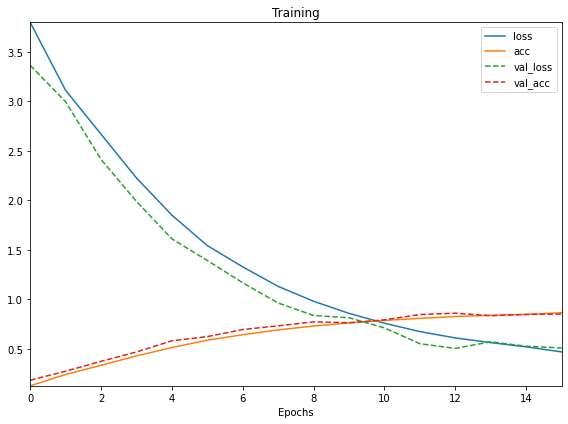

In [12]:
plt.figure(figsize=(8, 6))
plt.title("Training")
def plotline(label):
    return plt.plot(train_history[label], label=label, linestyle='--' if label[:3]=='val' else '-')

for label in train_history.keys():
    plotline(label=label)
plt.xlabel('Epochs')
plt.legend()
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()